# Credit Risk Resampling Techniques

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

# Read the CSV and Perform Basic Data Cleaning

In [3]:
columns = [
    "loan_amnt", "int_rate", "installment", "home_ownership",
    "annual_inc", "verification_status", "issue_d", "loan_status",
    "pymnt_plan", "dti", "delinq_2yrs", "inq_last_6mths",
    "open_acc", "pub_rec", "revol_bal", "total_acc",
    "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt",
    "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee",
    "recoveries", "collection_recovery_fee", "last_pymnt_amnt", "next_pymnt_d",
    "collections_12_mths_ex_med", "policy_code", "application_type", "acc_now_delinq",
    "tot_coll_amt", "tot_cur_bal", "open_acc_6m", "open_act_il",
    "open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il",
    "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc",
    "all_util", "total_rev_hi_lim", "inq_fi", "total_cu_tl",
    "inq_last_12m", "acc_open_past_24mths", "avg_cur_bal", "bc_open_to_buy",
    "bc_util", "chargeoff_within_12_mths", "delinq_amnt", "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl", "mort_acc",
    "mths_since_recent_bc", "mths_since_recent_inq", "num_accts_ever_120_pd", "num_actv_bc_tl",
    "num_actv_rev_tl", "num_bc_sats", "num_bc_tl", "num_il_tl",
    "num_op_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0",
    "num_sats", "num_tl_120dpd_2m", "num_tl_30dpd", "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m", "pct_tl_nvr_dlq", "percent_bc_gt_75", "pub_rec_bankruptcies",
    "tax_liens", "tot_hi_cred_lim", "total_bal_ex_mort", "total_bc_limit",
    "total_il_high_credit_limit", "hardship_flag", "debt_settlement_flag"
]

target = ["loan_status"]

In [4]:
# Load the data
file_path = Path('Resources/LoanStats_2019Q1.csv')
df = pd.read_csv(file_path, skiprows=1)[:-2]
df = df.loc[:, columns].copy()

In [5]:
# Check NA counts in the input
row_ct = df.shape[0]
row_na = (df.isna().sum(axis=1)>0).sum()
chk_na = df.isna().sum()
print('Shape\t\t',             df.shape, 
      '\nRows all na\t',       len(chk_na[chk_na==row_ct]), f'\t({len(chk_na[chk_na==row_ct])/row_ct:.2%})',
      '\nRows with na\t',      row_na, '\t({:.2%})'.format(row_na/row_ct),
      '\nTotal na values\t',   chk_na.sum(), 
      '\n\nColumns with na\n', chk_na[chk_na>0])

Shape		 (115675, 86) 
Rows all na	 0 	(0.00%) 
Rows with na	 33138 	(28.65%) 
Total na values	 49630 

Columns with na
 dti                        257
next_pymnt_d              2198
mths_since_rcnt_il        3517
il_util                  17319
all_util                    24
avg_cur_bal                  7
bc_open_to_buy            1323
bc_util                   1378
mo_sin_old_il_acct        3517
mths_since_recent_bc      1258
mths_since_recent_inq    14357
num_tl_120dpd_2m          3146
percent_bc_gt_75          1329
dtype: int64


In [6]:
# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')

# Drop the null rows
df = df.dropna()
df.shape

(82537, 86)

## Convert categorical data to numeric

In [7]:
# Remove the `Issued` loan status
issued_mask = df['loan_status'] != 'Issued'
df = df.loc[issued_mask]

# convert interest rate to numerical
df['int_rate'] = df['int_rate'].str.replace('%', '')
df['int_rate'] = df['int_rate'].astype('float') / 100

In [8]:
# Value counts for target i.e. loan_status
df['loan_status'].value_counts()

Current               68470
In Grace Period         171
Late (16-30 days)        89
Late (31-120 days)       87
Name: loan_status, dtype: int64

In [9]:
# Convert the target column values to low_risk and high_risk based on their values
df['loan_status'] = df['loan_status'].str.replace('Current', 'low_risk', regex=False)
df.loc[df['loan_status']!='low_risk', 'loan_status'] = 'high_risk'
df['loan_status'].value_counts();

In [10]:
# Check remaining columns for categorical data
chk_types = df.dtypes == 'object'

for col in chk_types[chk_types].index:
    print('Column: ', (col+30*" ")[:25], list(df[col].value_counts().index))

Column:  home_ownership            ['MORTGAGE', 'RENT', 'OWN', 'ANY']
Column:  verification_status       ['Not Verified', 'Source Verified', 'Verified']
Column:  issue_d                   ['Jan-2019', 'Feb-2019', 'Mar-2019']
Column:  loan_status               ['low_risk', 'high_risk']
Column:  pymnt_plan                ['n']
Column:  initial_list_status       ['w', 'f']
Column:  next_pymnt_d              ['May-2019', 'Apr-2019']
Column:  application_type          ['Individual', 'Joint App']
Column:  hardship_flag             ['N']
Column:  debt_settlement_flag      ['N']


In [11]:
# Drop columns with constant values: pymnt_plan, hardship_flag, debt_settlement_flag
df = df.drop(['pymnt_plan', 'hardship_flag', 'debt_settlement_flag'], axis=1)

In [12]:
# For columns with only 2 values, get dummies, dropping the first value
df = pd.get_dummies(df, columns=['initial_list_status', 'next_pymnt_d', 'application_type'], drop_first=True)

In [13]:
# For columns with more than 2 values, convert to numeric
# Notes: 
# For verification status, "Source Verified" may be same as "Verfied". Don't assume for now
# Column issue_d may be a time value, but keep as discreet values.
df = pd.get_dummies(df, columns=['home_ownership', 'verification_status', 'issue_d'])

# Split the Data into Training and Testing

In [14]:
# Create our features
df.reset_index(drop=True, inplace=True)

X = df.copy()
X = X.drop('loan_status', axis=1)

# Create our target
y = df['loan_status']

In [15]:
X.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,issue_d_Feb-2019,issue_d_Jan-2019,issue_d_Mar-2019
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,...,0.009285,0.526309,0.106747,0.357659,0.478007,0.373992,0.148001,0.371696,0.451066,0.177238
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,...,0.095914,0.499311,0.308793,0.479314,0.499520,0.483865,0.355104,0.483261,0.497603,0.381873
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,6293.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,12068.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,21735.000000,...,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000
max,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,587191.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
# Check the balance of our target values
y.value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [17]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)
X_train.shape

(51612, 89)

# Oversampling

In this section, you will compare two oversampling algorithms to determine which algorithm results in the best performance. You will oversample the data using the naive random oversampling algorithm and the SMOTE algorithm. For each algorithm, be sure to complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [18]:
# Imports for models and analysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.metrics import classification_report_imbalanced
from collections import Counter

### Naive Random Oversampling

In [19]:
# Resample the training data with the RandomOversampler
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

Counter(y_resampled)

Counter({'low_risk': 51352, 'high_risk': 51352})

In [20]:
# Train the Logistic Regression model using the resampled data
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled);

In [21]:
# Calculate the balanced accuracy score
y_pred = model.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.6435613248405591

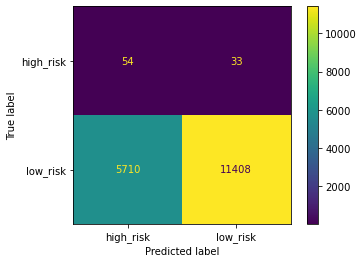

In [22]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=model.classes_).plot()

In [23]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.62      0.67      0.02      0.64      0.41        87
   low_risk       1.00      0.67      0.62      0.80      0.64      0.42     17118

avg / total       0.99      0.67      0.62      0.79      0.64      0.42     17205



### SMOTE Oversampling

In [24]:
# Resample the training data with SMOTE
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE(random_state=1, sampling_strategy='auto').fit_resample(
    X_train, y_train
)
Counter(y_resampled)

Counter({'low_risk': 51352, 'high_risk': 51352})

In [25]:
# Train the Logistic Regression model using the resampled data
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled);

In [26]:
# Calculated the balanced accuracy score
y_pred = model.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.6246993485381389

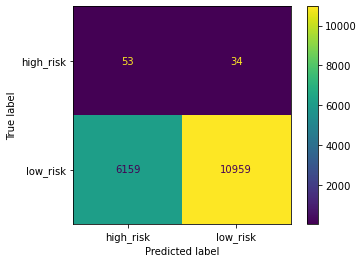

In [27]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=model.classes_).plot()

In [28]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.61      0.64      0.02      0.62      0.39        87
   low_risk       1.00      0.64      0.61      0.78      0.62      0.39     17118

avg / total       0.99      0.64      0.61      0.78      0.62      0.39     17205



# Undersampling

In this section, you will test an undersampling algorithms to determine which algorithm results in the best performance compared to the oversampling algorithms above. You will undersample the data using the Cluster Centroids algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [29]:
# Resample the data using the ClusterCentroids resampler
# Warning: This is a large dataset, and this step may take some time to complete
from imblearn.under_sampling import RandomUnderSampler
ros = RandomUnderSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({'high_risk': 260, 'low_risk': 260})

In [30]:
# Train the Logistic Regression model using the resampled data
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled);

In [31]:
# Calculated the balanced accuracy score
y_pred = model.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.5892688075870933

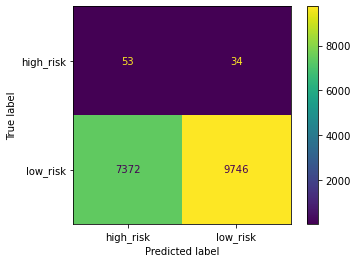

In [32]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=model.classes_).plot()

In [33]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.61      0.57      0.01      0.59      0.35        87
   low_risk       1.00      0.57      0.61      0.72      0.59      0.35     17118

avg / total       0.99      0.57      0.61      0.72      0.59      0.35     17205



# Combination (Over and Under) Sampling

In this section, you will test a combination over- and under-sampling algorithm to determine if the algorithm results in the best performance compared to the other sampling algorithms above. You will resample the data using the SMOTEENN algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [34]:
# Resample the training data with SMOTEENN
# Warning: This is a large dataset, and this step may take some time to complete
from imblearn.under_sampling import ClusterCentroids
cc = ClusterCentroids(random_state=1)
X_resampled, y_resampled = cc.fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({'high_risk': 260, 'low_risk': 260})

In [35]:
# Train the Logistic Regression model using the resampled data
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled);

In [36]:
# Calculated the balanced accuracy score
y_pred = model.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.5176039740382175

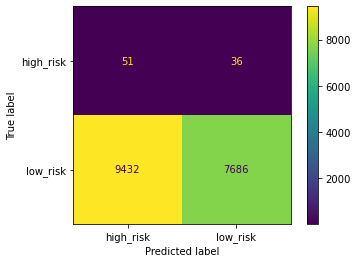

In [37]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=model.classes_).plot()

In [38]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.59      0.45      0.01      0.51      0.27        87
   low_risk       1.00      0.45      0.59      0.62      0.51      0.26     17118

avg / total       0.99      0.45      0.59      0.62      0.51      0.26     17205

